# Horizon Extension model

In this notebook, we will go through the task of horizon extension for a single predicted horizon. The objective is to enlarge a horizon covered area.
In the previous notebooks with seismic horizon detection models such as [Carcass Interpolation](https://github.com/gazprom-neft/seismiqb/blob/master/models/Carcass%20interpolation/01_M_cube.ipynb) and 
[Inter-cube generalization](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb), you can see that sometimes predicted horizons contain holes. The size and quantity of such holes depend on the difficulty of the target horizon and the quality of the cube.  
This notebook describes a model that is trained to fill in these holes.

* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Data preprocessing](#Data-preprocessing)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Validation](#Validation)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

# Task-description

Given a cube and a horizon with insufficient coverage we are going to train a model to extend this particular horizon.

We solve this task as a binary segmentation problem but unlike the [horizon detection model](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb) that sees only seismic images, the extension model also sees a part of a target-horizon.
Given incomplete information about the horizon of interest, the model can be trained to retrieve missing points on the horizon.

# Dataset

In [1]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
# some imports
import sys
import warnings
warnings.filterwarnings("ignore")

from copy import copy

import numpy as np
from scipy.special import binom
from scipy.ndimage.morphology import binary_fill_holes, binary_dilation
import torch.nn as nn
from tqdm.notebook import tqdm_notebook

sys.path.append('../../..')

from seismiqb import *
from seismiqb.src.controllers.torch_models import ExtensionModel

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow import D, B, V, P, R, L

# Holes sampling functions

In [3]:
import numpy as np
from scipy.special import binom
from scipy.ndimage.morphology import binary_fill_holes, binary_dilation

In [4]:
def bezier_figure(key_points_amount=7, radius=0.2, sharpness=0.05, scale=1.0, plot_size=(1, 1), 
                  resolution=None, unscaled_points_distance=.5, points_search_stop_iter=100):
    """ Bezier closed curve coordinates.        
    Creates Bezier closed curve which passes through random points.
    Code based on:  https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib    

    Parameters
    ----------
    key_points_amount : int
        Amount of angles (key points) in the random figure.
        Must be more than 1.
    radius : float
        Distance for control middle points in Bezier algorithm. 
        Is a number between 0 and 1.
    sharpness : float
        Degree of sharpness/edgy.
        If 0 then a curve will be the smoothest.
    scale : float
        Figure scale. 
        Is a number between 0 and 1. Fits to the plot_size.
    plot_size : sequence int
        Size of plotting area.
    resolution : int
        Amount of points in one curve between two key points.
    unscaled_points_distance : float
        Distance between all key points in a unit square.
        A number between 0 and 1.
    points_search_stop_iter : int
        Stop criterion for search of key points.
    """        
    resolution = resolution or int(scale*max(plot_size)*100)
    
    # Get key points of figure as random points which are far enough each other        
    key_points = np.random.rand(key_points_amount, 2)
    unscaled_points_distance = unscaled_points_distance**2
    
    for i in range(points_search_stop_iter):
        # Found distances between points and sort key_points by angles         
        shifted_points = key_points - np.mean(key_points, axis=0)
        angles = np.arctan2(shifted_points[:, 0], shifted_points[:, 1])
        key_points = key_points[np.argsort(angles)]

        squared_distances = np.sum(np.diff(key_points, axis=0)**2, axis=1)
        if np.all(squared_distances >= unscaled_points_distance):
            break
        key_points = np.random.rand(key_points_amount, 2)

    key_points *= scale*np.array(plot_size, float)
    key_points = np.vstack([key_points, key_points[0]]) 

    # Calculate figure angles in key points
    p = np.arctan(sharpness) / np.pi + .5
    diff_between_points = np.diff(key_points, axis=0)
    angles = np.arctan2(diff_between_points[:, 1], diff_between_points[:, 0])    
    angles = angles + 2*np.pi*(angles < 0)
    rolled_angles = np.roll(angles, 1)
    angles = p*angles + (1 - p)*rolled_angles + np.pi*(np.abs(rolled_angles - angles) > np.pi)
    angles = np.append(angles, angles[0])        

    # Create figure part by part: make curves between each pair of points
    curve_segments = []
    # Calculate control points for Bezier curve
    points_distances = np.sqrt(np.sum(diff_between_points**2, axis=1))
    radii = radius*points_distances
    middle_control_points_1 = np.transpose(radii*[np.cos(angles[:-1]), 
                                                  np.sin(angles[:-1])]) + key_points[:-1]
    middle_control_points_2 = np.transpose(radii*[np.cos(angles[1:] + np.pi), 
                                                  np.sin(angles[1:] + np.pi)]) + key_points[1:]
    curve_main_points_arr = np.hstack([key_points[:-1], middle_control_points_1,
                                       middle_control_points_2, key_points[1:]]).reshape(key_points_amount, 4, -1)
    
    # Get Bernstein polynomial approximation of each curve
    for i in range(key_points_amount):
        bezier_param_t = np.linspace(0, 1, num=resolution)            
        current_segment = np.zeros((resolution, 2))
        for point_num, point in enumerate(curve_main_points_arr[i]):
            polynomial_degree = np.power(bezier_param_t, point_num)
            polynomial_degree *= np.power(1 - bezier_param_t, 3 - point_num)
            bernstein_polynomial = binom(3, point_num)*polynomial_degree
            current_segment += np.outer(bernstein_polynomial, point)
        curve_segments.extend(current_segment)
        
    curve_segments = np.array(curve_segments)
    xy = np.unique(np.ceil(curve_segments).astype(int), axis=0)
    return xy 

def random_figures(horizon, n=10, noise_level=0, scale=1.0, locations=None):
    """ Create matrix of random figured holes for horizon.        
   
    Parameters
    ----------
    horizon
        Instance of Horizon class.
    n : int
        Amount of figured holes on horizon.
    noise_level : int
        Radius of noise scattering near the borders of figures.
    scale : float or sequence of float
        If float, each figure will have a random scale from exponential distribution with parameter scale.
        If sequence, each figure will have a provided scale.
    locations : ndarray
        If provided, an array of desired locations of figures.
    """  
    horizon_shape = horizon.shape
    filtering_matrix = np.zeros(horizon_shape)
    
    if isinstance(scale, float):
        figures_scale = []
        while len(figures_scale) < n:
            new_scale = np.random.exponential(scale, size=(n-len(figures_scale))*10)
            new_scale = new_scale[new_scale < .25]
            figures_scale.extend(new_scale)
        scale = figures_scale[:n]
        
    if locations is None:
        # Choose random non-bad traces
        traces_idxs = np.where(horizon.geometry.zero_traces == 0)
        locations_idxs = np.random.randint(0, len(traces_idxs[0]), n)
        locations = np.transpose(np.vstack([traces_idxs[0][locations_idxs],
                                            traces_idxs[1][locations_idxs]]))
        
    for i in range(n):
        key_points_amount = np.random.randint(2, 5)
        radius = np.random.random()
        sharpness = np.random.random()*np.random.randint(1, 5)
        
        xy = bezier_figure(key_points_amount, radius, sharpness, scale[i], horizon_shape)
        xy += locations[i, :]
               
        if noise_level:
            noise = noise_level*np.random.randn(*xy.shape) + xy
            xy = np.unique(np.vstack([xy, noise.astype(int)]), axis=0)
        
        #Shift figure in plotting area
        nonzero_borders = np.min(xy, axis=0)
        up_borders = np.max(xy, axis=0)   
        for j in range(2):
            nonzero_border = min(0, nonzero_borders[j])
            up_border = max(up_borders[j], horizon_shape[j]) - horizon_shape[j]
            xy[:, j] -= (up_border + nonzero_border + 1)

        # Cut figure if it is too big
        suited_x = (xy[:, 0] < horizon.i_length) & (xy[:, 0] >= 0)
        suited_y = (xy[:, 1] < horizon.x_length) & (xy[:, 1] >= 0)
        xy = xy[suited_x & suited_y]
        filtering_matrix[xy[:, 0], xy[:, 1]] = 1
    filtering_matrix = binary_fill_holes(filtering_matrix)
    filtering_matrix = horizon.put_on_full(filtering_matrix, False)
    return filtering_matrix

def add_noise(horizon, shape=1, n=None):
    """ Create matrix of random point holes for horizon.        
   
    Parameters
    ----------
    horizon
        Instance of Horizon class.
    n : int
        Amount of point holes on horizon. 
        If None, amount will be chosen randomly.
    """
    filtering_matrix = np.zeros(horizon.shape)
    if n is None:
        n = np.random.randint(horizon.size//1e5, horizon.size//1e4)
    x = np.random.randint(0, horizon.i_length, n)
    y = np.random.randint(0, horizon.x_length, n)
    
    filtering_matrix[x, y] = 1
    filtering_matrix = binary_dilation(filtering_matrix, np.ones((shape, shape)))
    filtering_matrix = horizon.put_on_full(filtering_matrix, False)
    return filtering_matrix

Load cube and a horizon with holes that could be predicted with one of the [horizon detection models](https://github.com/gazprom-neft/seismiqb/blob/master/models/Carcass%20interpolation/01_M_cube.ipynb).
You can find more information about dealing with seismic data and horizons in [our tutorials notebooks](https://github.com/gazprom-neft/seismiqb/tree/master/tutorials).

In [5]:
cube_path = "/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5"
horizon_dir = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon'

In [6]:
dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load(horizon_dir)
dataset.create_labels({dataset.indices[0]: [horizon_dir]})
dataset.modify_sampler(dst='train_sampler', finish=True)

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

In [7]:
init_horizon_copy = horizon.__copy__()

Let's take a look at the depth map of the loaded horizon. White color corresponds to missing points on the horizon.

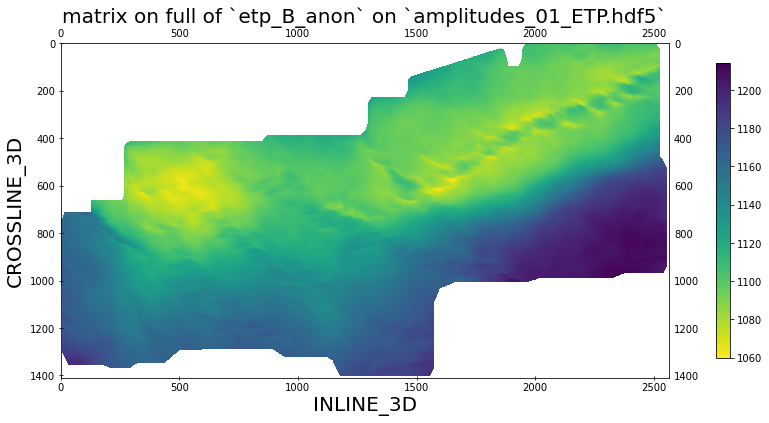

In [8]:
horizon.show()

In [9]:
filtering_matrix = np.zeros_like(geometry.zero_traces)

In [10]:
np.random.seed(0)
filtering_matrix1 = random_figures(horizon, n=20, noise_level=25, scale=1.0, locations=None)
filtering_matrix2 = add_noise(horizon, shape=5)
filtering_matrix = filtering_matrix1 + filtering_matrix2

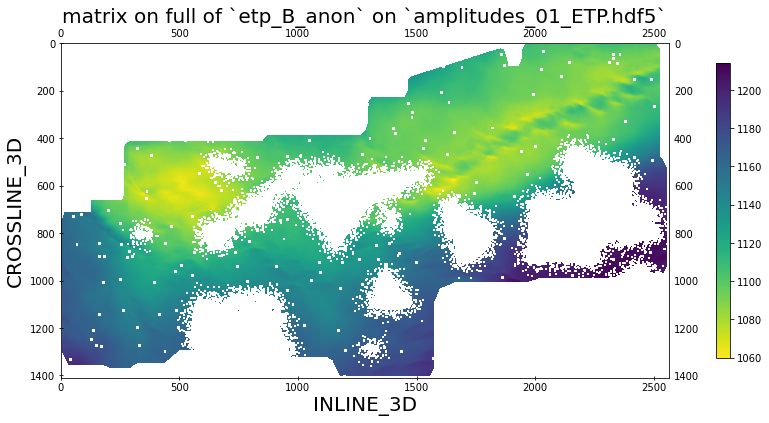

In [11]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

We can also call `evaluate` method that computes simple horizon statistics like percentage of labeled traces, number of holes, and also computes support correlation metric that allows assessing horizon quality. To learn more about metrics check out [metrics notebook](https://github.com/gazprom-neft/seismiqb/blob/master/datasets/04_Horizon_metrics.ipynb). In short, the greener the better.


Number of labeled points:                         2030730
Number of points inside borders:                  2352887
Perimeter (length of borders):                    9781
Percentage of labeled non-bad traces:             0.8336946079759588
Percentage of labeled traces inside borders:      0.8630801224198187
Number of holes inside borders:                   5734



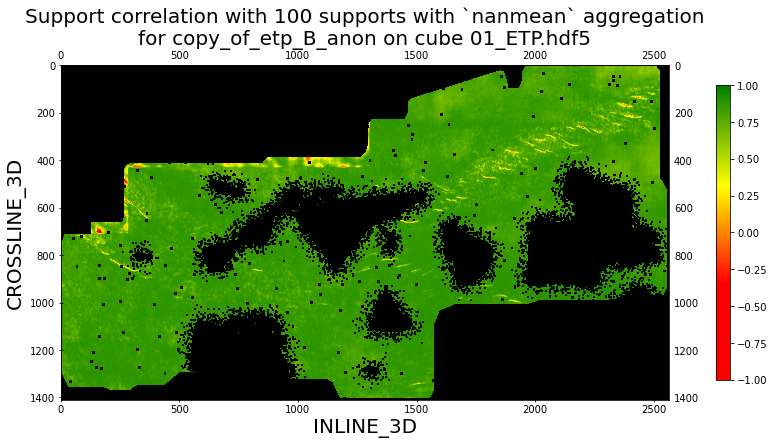

In [12]:
corrs = copy(horizon).evaluate(supports=100, plot=True)

# Data preprocessing

We train our models on 3D crops of fixed shape cut from the cube.

Let's define constants for batch size, crop shape and number of model training iterations.
We also define inference constants such as number of extension steps and stride size which will be explained in the inference section.

In [14]:
BATCH_SIZE = 64
CROP_SHAPE = (1, 64, 64)
NUM_ITERS = 300
N_STEPS = 7
STRIDE = 20

Let's define the load pipeline. It will
- sample BATCH_SIZE crops coordinate with `crop` action. Crops will be sampled in both xline and iline orientations (orientation depends on crop_shape, e.g, iline oriented crops have a shape (1, 64, 64) and xline crops - (64, 1, 64))
- create binary masks from the given horizon
- remove from the batch all crops that have less than 99 % horizon coverage using `mask_rebatch` with `threshold=0.8` because we don't want to use in training parts of the horizon that contain holes. Note that after this action actual batch size fed to the model will be less than `BATCH_SIZE`
- use the remaining crop coordinates load actual seismic data with `load_cubes`
- reshape crops of different orientations to the same shape by transposing xline oriented crops with `adaptive_reshape`
- normalize seismic data by dividing by 99 quantile of the data in the cube: this way, most of the data is in $[-1, 1]$ range

In [15]:
load = (Pipeline()
        .make_locations(points=D('train_sampler')(BATCH_SIZE),
              shape=CROP_SHAPE, side_view=True)
        .create_masks(dst='masks', width=3)
        .mask_rebatch(src='masks', threshold=0.8)
        .load_cubes(dst='images')
        .adaptive_reshape(src=['images', 'masks'],
                          shape=CROP_SHAPE)
        .normalize(mode='q', src='images')
       )

To train a model to extend a specific horizon we have to provide some data about it to the model. We provide a part of a target mask as an input to our model.
To do so we partially zero out the loaded mask and leave 10-40 percent of it nonzero (depending on the size and the number of holes in the horizon).

Here we define a mask distortion pipeline that thins out the loaded mask and saves it into a new prior_mask-component of the batch.

In [16]:
def functor(scale):
    return lambda m: np.sin(m[:, 0] * scale)

distort = (Pipeline()
            .transpose(src='masks', order=(1, 2, 0))
            .filter_out(src='masks', dst='prior_masks',
                        expr=lambda m: m[:, 0],
                        low=P(R('uniform', low=0., high=0.4)),
                        length=P(R('uniform', low=0.30, high=0.5)))
            .transpose(src=['masks', 'prior_masks'], order=(2, 0, 1))
          )

Let's combine pipelines and take a look at the seismic data, the full mask that is our NN target, and the thinned out version of it that is fed to the model.

In [17]:
show_pipeline = (load + distort) << dataset
batch = show_pipeline.next_batch(1)

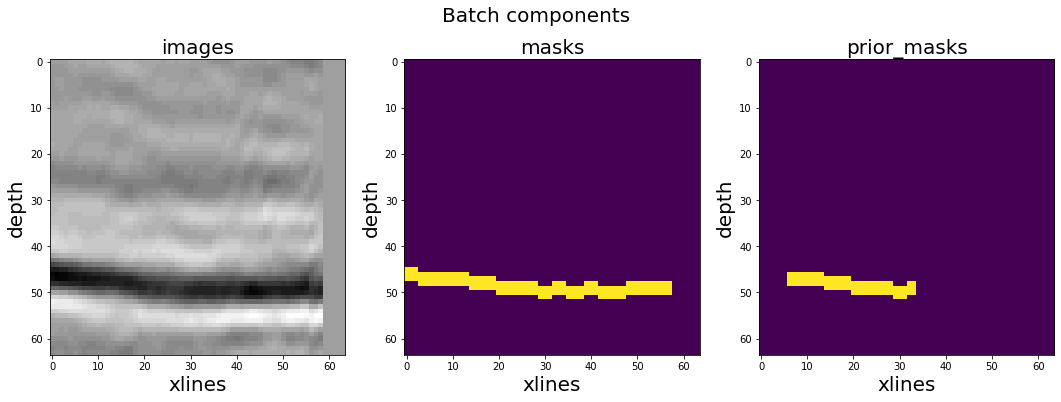

In [18]:
batch.plot_components('images', 'masks', 'prior_masks', idx=0, mode='separate')

We also define an augmentation pipeline with rotation on a random angle and random flip:

In [19]:
augment = (Pipeline()
            .transpose(src=['images', 'masks', 'prior_masks'], order=(1, 2, 0))
            .rotate(angle=P(R('uniform', -30, 30)),
                    src=['images', 'masks', 'prior_masks'], p=0.3)
            .flip(src=['images', 'masks', 'prior_masks'], axis=1, p=0.3)
            .transpose(src=['images', 'masks', 'prior_masks'], order=(2, 0, 1))
          )

# Model architecture

In previous cells we have created `prior_masks` component that is a thin-out copy of an actual `mask` component. Our idea is to provide a partial horizon to the model along with a seismic data and train model to restore it. 



We modify the traditional [EncoderDecoder](https://github.com/analysiscenter/batchflow/blob/master/batchflow/models/torch/encoder_decoder.py) architecture by an additional encoding branch with prior information about the horizon of interest. Information from this new branch is repeatedly incorporated into the main branch before each of the downsampling steps. 
For the sake of brevity, we don't provide model code in this notebook, but you can find our PyTorch implementation [here]().

<p align="center">
    <img src="images/architecture.png" alt="Drawing" />
</p>

Both encoder branches have a similar layout. We use 4 downsampling steps with ResNet blocks and increase the number of filters from 32 twice at each step.

We optimize the Dice loss using Adam optimizer with starting `learning rate = 1e-3` and exponential decay by `gamma=0.1` every 100 epochs.

In [20]:
MODEL_CONFIG = {
    # Model layout
    'body/encoder': {
        'num_stages': 3,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [32, 64, 128],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 128,
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 3,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32],
            'attention': 'scse',
        },
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': 'bdice',
    'optimizer': {'name': 'Adam', 'lr': 0.005,},
    'decay': {'name': 'exp', 'gamma': 0.1, 'frequency': 150}
    }

# Training

Define pipeline that initializes a model with the model_config defined above and feeds seismic data, prior masks and true masks to the model:

In [21]:
train_model = (Pipeline()
                .init_variable('loss_history', default=[])
                .init_model('dynamic', ExtensionModel, 'base', MODEL_CONFIG)
                .train_model('base', fetches='loss', save_to=V('loss_history', mode='a'),
                             images=B('images'),
                             prior_masks=B('prior_masks'),
                             masks=B('masks'))
                )

Combine all pipelines to one and feed actual dataset to it:

In [22]:
training_pipeline = (load + distort + augment + train_model) << dataset

Run training pipeline for NUM_ITERS iterations and show loss function plot:

  0%|                                                                                                         …

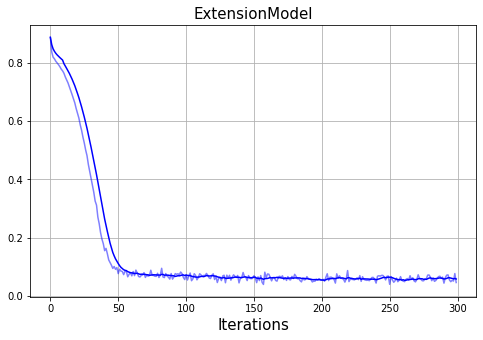

In [24]:
training_pipeline.run(D('size'), n_iters=NUM_ITERS, bar='n')
plot_loss(training_pipeline.v('loss_history'), ylabel='', title='ExtensionModel')

# Inference

To fill in the holes in the initial horizon we have to generate crops coordinates next to them so that each crop contains a partial horizon that is used as an input to the trained model. After extracting predicted horizons and merging them to the initial one we repeat inference step with extended horizon boundaries.


First, we define an inference pipeline. It will:
- import trained model from the training pipeline
- get crop coordinates from `grid_gen` and load crops of seismic data in different orientations
- create a prior mask from the known horizon with holes
- reshape crops of different orientations to the same shape
- normalize seismic data
- feed seismic data and prior masks to the model and fetch predictions
- extract horizons from predictions and save them to pipeline variable `predicted_horizons`

In [25]:
inference_pipeline = (
    Pipeline()
    # Init everything
    .init_variable('predicted_horizons', default=list())
    .import_model('base', training_pipeline)

    # Load data
    .make_locations(points=L(D('grid_gen')), shape=L(D('shapes_gen')))
    .load_cubes(dst='images')
    .create_masks(dst='prior_masks', width=3)
    .adaptive_reshape(src=['images', 'prior_masks'],
                      shape=CROP_SHAPE)
    .normalize(mode='q', src='images')

    # Use model for prediction
    .predict_model('base',
                   B('images'),
                   B('prior_masks'),
                   fetches='predictions',
                   save_to=B('predicted_masks'))
    .transpose(src='predicted_masks', order=(1, 2, 0))
    .masks_to_horizons(src_masks='predicted_masks', threshold=0.5, minsize=16,
                       order=L(D('orders_gen')), dst='horizons', skip_merge=True)
    .update(V('predicted_horizons', mode='e'), B('horizons'))
) << dataset

As we could see previously, the horizon that we work with contains only a small amount of tiny holes; thus, we can set the number of performed extension steps to a small number.

In [26]:
%%time

initial_horizon = copy(dataset.labels[0][0])
prev_len = len(horizon)

for _ in tqdm_notebook(range(N_STEPS)):

    # Create generator of crops locations near horizon boundaries
    dataset.make_extension_grid(dataset.indices[0],
                                crop_shape=CROP_SHAPE,
                                stride=STRIDE, # Overlap size of neighbouring crops
                                labels_src='labels',
                                batch_size=BATCH_SIZE * 4) # Prediction-time, we can enlarge batch size

    # Run inference pipeline for all crops in the generated grid
    inference_pipeline.run(1, n_iters=dataset.grid_iters)


    # Merge horizons extracted from predicted masks to the initial one
    horizons = [*inference_pipeline.v('predicted_horizons')]
    for hor in horizons:
        
        # Check if the horizon can be merged
        merge_code, _ = Horizon.verify_merge(dataset.labels[0][0], hor,
                                             mean_threshold=5.5, adjacency=5)

        # Merge
        if merge_code == 3:
            _ = dataset.labels[0][0].overlap_merge(hor, inplace=True)


    curr_len = len(dataset.labels[0][0])

    # Break if the length of extended area is too small
    if (curr_len - prev_len) < 5:
        break

    print(f'Extended from {prev_len} to {curr_len}, + {curr_len - prev_len}')
    prev_len = curr_len

  0%|          | 0/7 [00:00<?, ?it/s]

Extended from 2030730 to 2207952, + 177222
Extended from 2207952 to 2359064, + 151112
Extended from 2359064 to 2415167, + 56103
Extended from 2415167 to 2426508, + 11341
Extended from 2426508 to 2427203, + 695
Extended from 2427203 to 2427332, + 129
Extended from 2427332 to 2427429, + 97
CPU times: user 26min 51s, sys: 46.3 s, total: 27min 37s
Wall time: 27min 39s


# Validation

Let's call `evaluate` method for predicted horizon and see if we have actually extended our initial horizon.


Number of labeled points:                         2427429
Number of points inside borders:                  2431136
Perimeter (length of borders):                    8473
Percentage of labeled non-bad traces:             0.9965551641746927
Percentage of labeled traces inside borders:      0.9984751984257565
Number of holes inside borders:                   1011



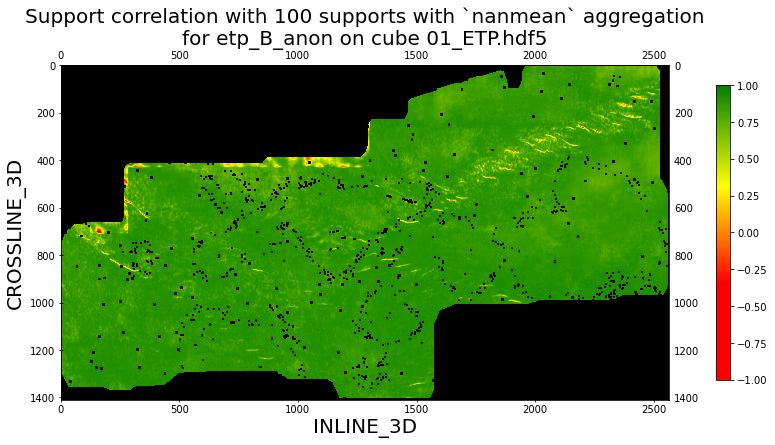

In [27]:
_ = dataset.labels[0][0].evaluate(supports=100, plot=True)

Recall what we began with:


Number of labeled points:                         2030730
Number of points inside borders:                  2352887
Perimeter (length of borders):                    9781
Percentage of labeled non-bad traces:             0.8336946079759588
Percentage of labeled traces inside borders:      0.8630801224198187
Number of holes inside borders:                   5734



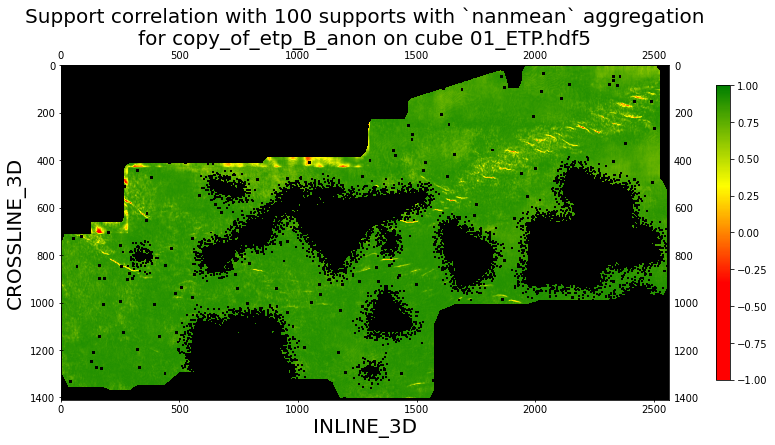

In [28]:
corrs = initial_horizon.evaluate(supports=100, plot=True)


Number of labeled points:                         2424324
Number of points inside borders:                  2424324
Perimeter (length of borders):                    8242
Percentage of labeled non-bad traces:             0.995280439441338
Percentage of labeled traces inside borders:      1.0
Number of holes inside borders:                   0



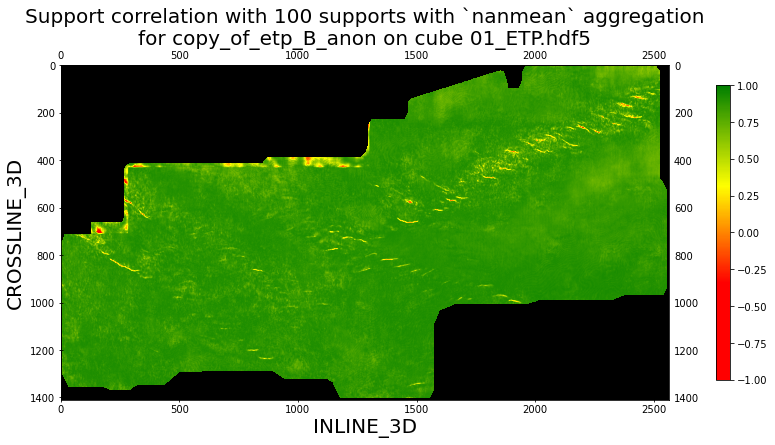

In [29]:
corrs = init_horizon_copy.evaluate(supports=100, plot=True)


Comparing horizons:
                                   etp_B_anon
                           copy_of_etp_B_anon
—————————————————————————————————————————————
Rate in 5ms:                            1.000
Mean/std of errors:               -0.01 / 0.14
Mean/std of abs errors:           0.02 / 0.14
Max error/abs error:                12 /   12
—————————————————————————————————————————————
Lengths of horizons:                  2427429
                                      2424324
—————————————————————————————————————————————
Average heights of horizons:          1130.19
                                      1130.12
—————————————————————————————————————————————
Coverage of horizons:                  0.9966
                                       0.9953
—————————————————————————————————————————————
Solidity of horizons:                  0.9985
                                       1.0000
—————————————————————————————————————————————
Number of holes in horizons:             1011
            

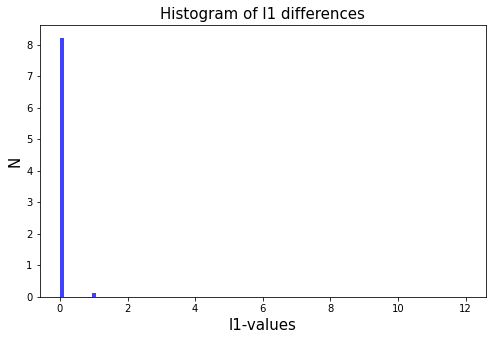

CPU times: user 868 ms, sys: 8.03 ms, total: 876 ms
Wall time: 872 ms


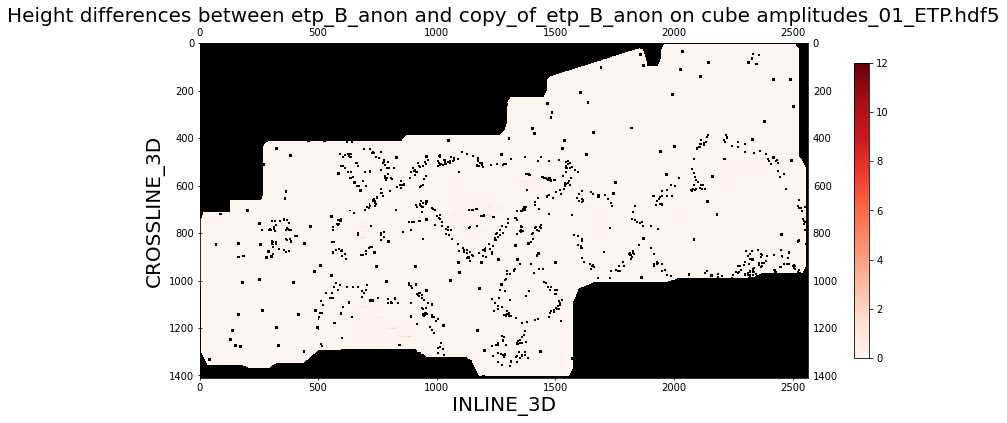

In [30]:
%%time
# Evaluate against seismic data
hm = HorizonMetrics((dataset.labels[0][0], init_horizon_copy))

_ = hm.evaluate('compare', plot=True)

So we have enlarged the percentage of labeled non-bad traces from 88.9 % to 99.3 %.

We can also take a look at the slides in the problematic region with horizons on it.

Initial horizon with holes at the iline oriented slide at iline=1800:

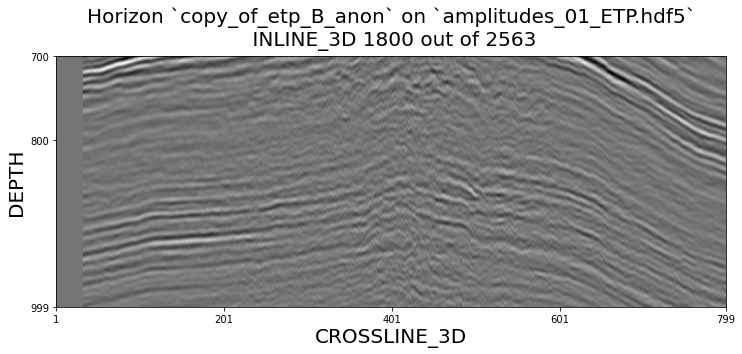

In [31]:
initial_horizon.show_slide(loc=1800, width=2, zoom_slice=(slice(1, 800, None), slice(700, 1000, None)))

Extended horizon at the iline oriented slide at iline=1800:

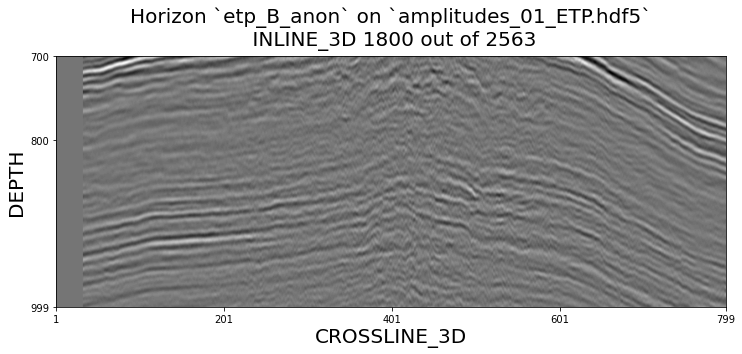

In [32]:
dataset.labels[0][0].show_slide(loc=1800, width=2, zoom_slice=(slice(1, 800, None), slice(700, 1000, None)))

There are some fluctuation points but it looks like the extended region respects fault planes in the cube. But a decision whether the red regions on the predicted horizon metric map correspond to a difficult geology structure or they are actual model's faults must be referred to an expert.

We also have a manually labeled version of this horizon. We can load it and see how an expert labeled this slide:

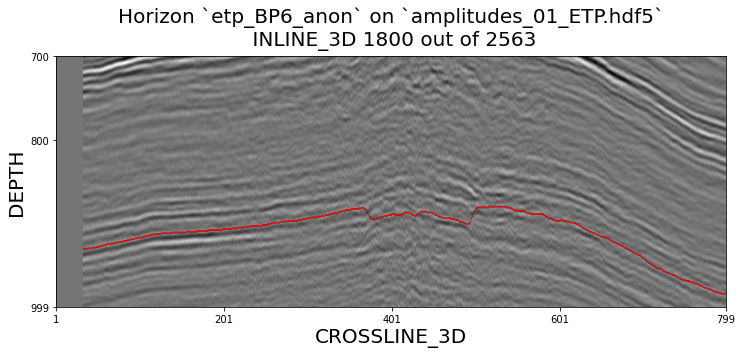

In [33]:
expert_path = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_BP6_anon'

expert_horizon = Horizon(expert_path, geometry=dataset.geometries[dataset.indices[0]])
expert_horizon.show_slide(loc=1800, width=2, zoom_slice=(slice(1, 800, None), slice(700, 1000, None)))

We can also compute the same metric for the manualy labeled horizon:


Number of labeled points:                         2903662
Number of points inside borders:                  2903662
Perimeter (length of borders):                    8646
Percentage of labeled non-bad traces:             1.192067558358171
Percentage of labeled traces inside borders:      1.0
Number of holes inside borders:                   0



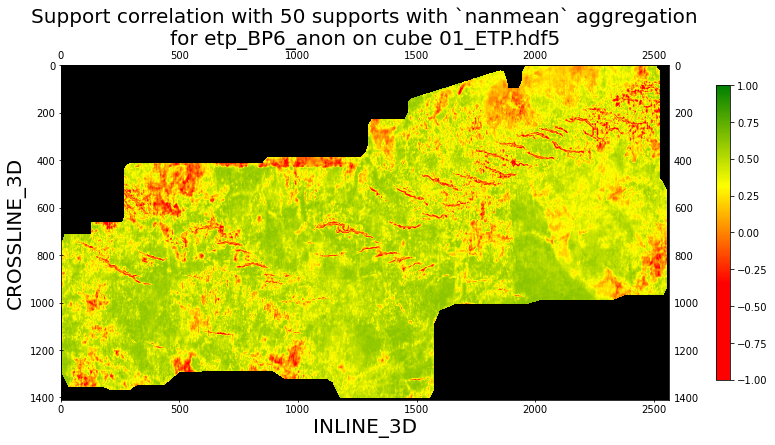

In [34]:
_ = expert_horizon.evaluate()

As was mentioned above considering metric - the greener the better, but red regions don't necessarily indicate badly traced horizon, it can be a sign of a change in rock properties.
Our predicted horizon has a lot of red regions. Nevertheless, since 
horizon labeled by an expert also have red regions in the same places, we 
can assume that they correspond to the changes in rock properties of the cube and the extended horizon quality is quite satisfying.

# Criticism

The initial horizon quality might be not satisfying enough and extended horizon may need some post-processing steps such as running through an [Enhancement]() model.

# Proposals for the improvement and further development

The proposed architecture might be not optimal and extensive research on different numbers of blocks, filters and combine operations between branches must be performed.